# <b> Import Libraries </b>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

----
----
# <b> Load the Data </b>

In [4]:
# Load the data
x_train = pd.read_csv('../data-challenge/x_train_sncf.csv')
x_test = pd.read_csv('../data-challenge/x_test_sncf.csv')
y_train = pd.read_csv('../data-challenge/y_train_sncf.csv')

----
----
# <b> Merge the training DF </b>

In [5]:
x_train['index'] = x_train['date'].str.cat(x_train['station'], sep='_')
x_train.head()

,date,station,job,ferie,vacances,index
0,2015-01-01,1J7,1,1,1,2015-01-01_1J7
1,2015-01-01,O2O,1,1,1,2015-01-01_O2O
2,2015-01-01,8QR,1,1,1,2015-01-01_8QR
3,2015-01-01,UMC,1,1,1,2015-01-01_UMC
4,2015-01-01,FK3,1,1,1,2015-01-01_FK3


In [6]:
data = pd.merge(x_train, y_train, on='index')
data = data[['date', 'station', 'index', 'job', 'ferie', 'vacances', 'y']] # reorered columns
data.head()

,date,station,index,job,ferie,vacances,y
0,2015-01-01,1J7,2015-01-01_1J7,1,1,1,7
1,2015-01-01,O2O,2015-01-01_O2O,1,1,1,0
2,2015-01-01,8QR,2015-01-01_8QR,1,1,1,9
3,2015-01-01,UMC,2015-01-01_UMC,1,1,1,9
4,2015-01-01,FK3,2015-01-01_FK3,1,1,1,28


----
----
# <b> Data exploration </b>

## Get the number of stations in the dataset

In [7]:
y_array = data.groupby('station')['y'].apply(np.array).to_dict()
print(len(y_array))

439


## Example of a time series over a period of time for a certain station 'O2O'

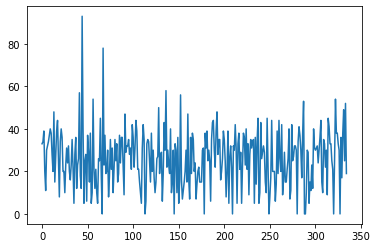

In [8]:
y_array['O2O']
plt.plot(y_array['O2O'][730:1065])

----
----
# <b> Define X_train and Y_train to train a model </b>

In [9]:
data['date'] = pd.to_datetime(data['date'])
data['day_of_week'] = data['date'].dt.dayofweek + 1
data['day_of_week_cos'] = np.cos(2 * np.pi * (data['day_of_week'] - 1) / 7)
data['day_of_week_sin'] = np.sin(2 * np.pi * (data['day_of_week'] - 1) / 7)

data['day_of_year'] = data['date'].dt.dayofyear

X_station = data['station']
station_mapping = {station: i for i, station in enumerate(X_station.unique())}
data['station_id'] = data['station'].map(station_mapping)

print(data.head())

        date station           index  job  ferie  vacances   y  day_of_week  \
0 2015-01-01     1J7  2015-01-01_1J7    1      1         1   7            4   
1 2015-01-01     O2O  2015-01-01_O2O    1      1         1   0            4   
2 2015-01-01     8QR  2015-01-01_8QR    1      1         1   9            4   
3 2015-01-01     UMC  2015-01-01_UMC    1      1         1   9            4   
4 2015-01-01     FK3  2015-01-01_FK3    1      1         1  28            4   

   day_of_week_cos  day_of_week_sin  day_of_year  station_id  
0        -0.900969         0.433884            1           0  
1        -0.900969         0.433884            1           1  
2        -0.900969         0.433884            1           2  
3        -0.900969         0.433884            1           3  
4        -0.900969         0.433884            1           4  


In [10]:
# Define the X_train and Y_train
X_train = data[['job', 'ferie', 'vacances', 'day_of_week']]
y_train = data['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

station_name = 'O2O'  # Replace 'O2O' with the desired station name

X_train_station = X_train[data['station'] == station_name]
y_train_station = y_train[data['station'] == station_name]
X_train, X_val, y_train, y_val = train_test_split(X_train_station, y_train_station, test_size=0.2, random_state=42)


/tmp/ipykernel_38286/656561680.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_station = X_train[data['station'] == station_name]


----
----
# <b> Do the training </b>

In [11]:
def mean_absolute_percentage_error(y_true, y_pred, eps=1e-2):
    return np.mean(np.abs((y_true+eps - y_pred+eps) / (y_true+eps))) * 100

In [12]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=500, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

MAPE = mean_absolute_percentage_error(y_val, y_pred)
print(f"MAPE: {MAPE:.2f}%")

MAPE: 6804.68%


----
----
# <b> Define XTEST </b>

In [11]:
x_test['date'] = pd.to_datetime(x_test['date'])
x_test['day_of_week'] = x_test['date'].dt.dayofweek + 1
print(x_test.head())
x_test['day_of_week_cos'] = np.cos(2 * np.pi * (x_test['day_of_week'] - 1) / 7)
x_test['day_of_week_sin'] = np.sin(2 * np.pi * (x_test['day_of_week'] - 1) / 7)
X_test = x_test[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin']]

            index       date station  job  ferie  vacances  day_of_week
0  2023-01-01_1J7 2023-01-01     1J7    0      1         1            7
1  2023-01-01_O2O 2023-01-01     O2O    0      1         1            7
2  2023-01-01_8QR 2023-01-01     8QR    0      1         1            7
3  2023-01-01_L58 2023-01-01     L58    0      1         1            7
4  2023-01-01_UMC 2023-01-01     UMC    0      1         1            7


----
----
# <b> Training and Testing for all the stations </b>

In [12]:
X_train = data[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin']]
y_train = data['y']

In [13]:
# Create an empty y_test dataframe
y_test = pd.DataFrame()
# Convert 'date' column to string type
x_test['date'] = x_test['date'].astype(str)
# First column name is 'index'
y_test['index'] = x_test['date'].str.cat(x_test['station'], sep='_')
# Second column name is 'y'
y_test['y'] = 0

print(y_test.head())

            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0


In [23]:
X_train = data[['date', 'y']]

X_train['date'] = pd.to_datetime(X_train['date'])
import tsfel

cfg = tsfel.get_features_by_domain()

X_train = tsfel.time_series_features_extractor(cfg, X_train, fs=1.0, window_size=50, overlap=0.5)



C:\Users\matte\AppData\Local\Temp\ipykernel_21064\2010181787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['date'] = pd.to_datetime(X_train['date'])


*** Feature extraction started ***


TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [17]:
X_train = data[['date', 'y']]
print(X_train.head())
from prophet import Prophet

# Create a model for each station
idx = 1
for station in X_station.unique():
    print(f"Index {idx} out of {len(X_station.unique())}")
    idx += 1
    # print(f"Processing station: {station}")
    X_train_station = X_train[data['station'] == station]
    X_train_station = X_train_station.rename(columns={'date': 'ds', 'y': 'y'})
    model = Prophet()
    model.fit(X_train_station)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    y_test.loc[y_test['index'].str.contains(station), 'y'] = forecast['yhat'].values[-365:].tolist()

    # y_test.loc[y_test['index'].str.contains(station), 'y'] = forecast['yhat'].values[-365:]

# save y_test dataframe to a csv file
y_test.to_csv('y_test_submit_prophet.csv', index=False)

        date   y
0 2015-01-01   7
1 2015-01-01   0
2 2015-01-01   9
3 2015-01-01   9
4 2015-01-01  28
Index 1 out of 439


17:38:57 - cmdstanpy - INFO - Chain [1] start processing
17:39:01 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
for i, name_station in enumerate(y_array):
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    X_test_station = X_test[x_test['station'] == name_station]
    model = RandomForestRegressor(n_estimators=40, random_state=42)
    model.fit(X_train_station, y_train_station)
    y_pred = model.predict(X_test_station)

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred

# save y_test dataframe to a csv file
y_test.to_csv('y_test_submit_each_station_RF.csv', index=False)

In [67]:
import xgboost as xgb  # For XGBoost
for i, name_station in enumerate(y_array):
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    X_test_station = X_test[x_test['station'] == name_station]
    # model = RandomForestRegressor(n_estimators=200, random_state=42)
    model = xgb.XGBRegressor(n_estimators=40, learning_rate=0.1, random_state=42)
    model.fit(X_train_station, y_train_station)
    y_pred = model.predict(X_test_station)

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred

# save y_test dataframe to a csv file
y_test.to_csv('y_test_submit_each_station_XG.csv', index=False)

In [70]:
from sklearn.svm import SVR
for i, name_station in enumerate(y_array):
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    X_test_station = X_test[x_test['station'] == name_station]
    
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    model.fit(X_train_station, y_train_station)
    y_pred = model.predict(X_test_station)

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred
    
# save y_test dataframe to a csv file
y_test.to_csv('y_test_submit_each_station_SVR.csv', index=False)
    



In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

for i, name_station in enumerate(y_array):
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    X_test_station = X_test[x_test['station'] == name_station]
    
    base_model = RandomForestRegressor(n_estimators=50, random_state=42)
    model = BaggingRegressor(base_model, n_estimators=10, random_state=42)
    model.fit(X_train_station, y_train_station)
    y_pred = model.predict(X_test_station)

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred
    y_test.to_csv('y_test_submit_Bagging_RF.csv', index=False)
    
    # save y_test dataframe to a csv file
    y_test.to_csv('y_test_submit_each_station_Bagging_RF.csv', index=False)
    break


In [74]:
import pandas as pd
# Define the file paths and output file name
output_file = 'y_test_merged_RG_XG_SVR.csv'
csv_files = ['y_test_submit_each_station_RF.csv', 'y_test_submit_each_station_XG.csv', 'y_test_submit_each_station_SVR.csv']

# Define a function to calculate the mean
def calculate_mean(csv_files, output_file):
    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        dfs.append(df)

    merged_df = pd.concat(dfs)
    mean_df = merged_df.groupby('index')['y'].mean().reset_index()

    mean_df.to_csv(output_file, index=False)

# Call the function
calculate_mean(csv_files, output_file)


In [75]:
import pandas as pd

# Load the three CSV files
df1 = pd.read_csv('y_test_submit_each_station_RF.csv')
df2 = pd.read_csv('y_test_submit_each_station_XG.csv')
df3 = pd.read_csv('y_test_submit_each_station_SVR.csv')

# Assuming 'index' is the name of your index column and it's the same across all three DataFrames
# Set 'index' as the index of each DataFrame
df1.set_index('index', inplace=True)
df2.set_index('index', inplace=True)
df3.set_index('index', inplace=True)

# Calculate the mean of the 'y' values across the three DataFrames
mean_y = (df1['y'] + df2['y'] + df3['y']) / 3

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_y, columns=['y'])

# Reset the index if you want 'index' as a column in the CSV
mean_df.reset_index(inplace=True)

# Save the new DataFrame to a CSV file
mean_df.to_csv('mean_y_values.csv', index=False)


----
----
# <b> Now let's do Deep Learning ! </b> 

In [49]:
# Create an empty y_test dataframe
y_test = pd.DataFrame()
# Convert 'date' column to string type
x_test['date'] = x_test['date'].astype(str)
# First column name is 'index'
y_test['index'] = x_test['date'].str.cat(x_test['station'], sep='_')
# Second column name is 'y'
y_test['y'] = 0

print(y_test.head())

            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class TimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(TimeSeriesRegression, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.fc(output)

# Define the neural network architecture
class ComplexTimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(ComplexTimeSeriesRegression, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, _ = self.lstm1(x)
        output, _ = self.lstm2(output)
        output = self.fc1(output)
        output = self.fc2(output)
        return output

# Define the loss function and optimizer
criterion = nn.MSELoss()
learning_rate = 0.001
num_epochs = 100

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Create an instance of the model
input_size = X_train_tensor.shape[1]
hidden_size = 64
num_layers = 2


# Train the model for each station
for name_station in y_array:
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    X_test_station = X_test[x_test['station'] == name_station]

    # Convert the data to PyTorch tensors
    X_train_tensor_station = torch.tensor(X_train_station.values, dtype=torch.float32)
    y_train_tensor_station = torch.tensor(y_train_station.values, dtype=torch.float32)
    X_test_tensor_station = torch.tensor(X_test_station.values, dtype=torch.float32)

    input_size = X_train_tensor_station.shape[0]
    print(input_size)
    model = ComplexTimeSeriesRegression(input_size, hidden_size, num_layers)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor_station)
        loss = criterion(outputs, y_train_tensor_station)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    with torch.no_grad():
        outputs = model(X_test_tensor_station)
        predictions = outputs.numpy().flatten()

    # Update the y_test dataframe with the predictions
    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = predictions
    # Save y_test dataframe to a csv file
    y_test.to_csv('y_deep.csv', index=False)
    break

# Save y_test dataframe to a csv file
# y_test.to_csv('y_test_submit_each_station.csv', index=False)

2898


c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2898])) that is different to the input size (torch.Size([2898, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [26]:
import pandas as pd

# Load the two CSV files
df1 = pd.read_csv('y_deep_deep.csv')
df2 = pd.read_csv('y_deep_DL.csv')

# Calculate the mean of the 'y' values across the two DataFrames
mean_y = (df1['y'] + df2['y']) / 2

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame({'index': df1['index'], 'y': mean_y})

# Save the new DataFrame to a CSV file
mean_df.to_csv('mean_y_values.csv', index=False)

